# Librerias

In [11]:
!pip install factor-analyzer

In [12]:
import pandas as pd
import os
import cv2
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import gc
import umap
from tqdm.notebook import tqdm
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import trustworthiness, _utils
from sklearn.neighbors import NearestNeighbors

In [13]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocesamiento de las imágenes

## Carga de las imágenes

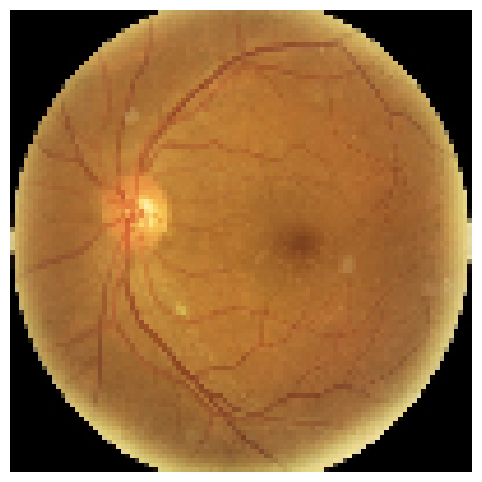


--- Contenido de la matriz (segmento central) ---
Forma del segmento: (5, 5, 3)
[[[ 47 116 179]
  [ 48 116 182]
  [ 48 117 179]
  [ 46 116 176]
  [ 48 112 176]]

 [[ 41 107 172]
  [ 48 116 182]
  [ 49 117 182]
  [ 44 112 176]
  [ 45 112 175]]

 [[ 45 116 180]
  [ 50 118 183]
  [ 48 116 181]
  [ 43 111 176]
  [ 45 109 174]]

 [[ 52 120 185]
  [ 47 118 181]
  [ 49 120 184]
  [ 45 113 178]
  [ 43 107 172]]

 [[ 48 114 179]
  [ 44 114 178]
  [ 50 121 186]
  [ 46 115 177]
  [ 43 109 172]]]


In [ ]:
folder_path = '/content/drive/MyDrive/enfermedades oculares/preprocessed_images'
IMG_SIZE = (100, 100)

def load_all_images(folder, img_size):

    images_list = [] # Lista para almacenar las matrices de imágenes

    # Verifica si la carpeta existe.
    if not os.path.exists(folder):
        print(f"Error: La carpeta '{folder}' no fue encontrada.")
        return np.array([])

    for filename in os.listdir(folder):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(folder, filename)

            # Carga la imagen a color
            img = cv2.imread(file_path)

            if img is not None:
                img_resized = cv2.resize(img, img_size)
                images_list.append(img_resized)
            else:
                print(f"Advertencia: No se pudo cargar la imagen {filename}. Se omitirá.")

    return images_list

#Llama a la función para cargar todas las imágenes en una lista
all_images = load_all_images(folder_path, IMG_SIZE)


# Visualiza la matriz de la primera imagen
if len(all_images) > 0:
    # Selecciona la primera imagen de la lista
    first_image = all_images[0]

    # Convierte el formato de color de BGR (OpenCV) a RGB (Matplotlib)
    first_image_rgb = cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB)


    # Define el tamaño del segmento que quieres visualizar (por ejemplo, 5x5 píxeles)
    target_size = 5

    # Obtiene las dimensiones de la imagen
    h, w, c = first_image.shape

    # Calcula la esquina superior izquierda del segmento central
    start_y = (h - target_size) // 2
    start_x = (w - target_size) // 2


    # Extrae el segmento central de la matriz
    center_segment = first_image[start_y : start_y + target_size,
                             start_x : start_x + target_size]


    # Muestra la imagen usando Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(first_image_rgb)
    #plt.title(f"Visualización de la Matriz de una Imagen ({first_image.shape[0]}x{first_image.shape[1]}x{first_image.shape[2]})")
    plt.axis('off')
    plt.show()

    print("\n--- Contenido de la matriz (segmento central) ---")
    print(f"Forma del segmento: {center_segment.shape}")
    print(center_segment)
else:
    print("No se encontraron imágenes. Por favor, revisa la ruta y los archivos.")


In [ ]:
#Características de las imagenes convertidas en matrices

if len(all_images) > 0:
    print("--- Información de la variable `all_images` ---")

    # 1. Tipo de dato
    print(f"Tipo de `all_images`: {type(all_images)}")

    # 2. Número total de elementos (imágenes)
    print(f"Número de imágenes en la lista: {len(all_images)}")

    # 3. Inspeccionar el primer elemento de la lista
    first_image_matrix = all_images[300]
    print(f"\nTipo del primer elemento: {type(first_image_matrix)}")
    print(f"Forma (dimensiones) de la matriz: {first_image_matrix.shape}")


else:
    print("La lista `all_images` está vacía.")

--- Información de la variable `all_images` ---
Tipo de `all_images`: <class 'list'>
Número de imágenes en la lista: 6392

Tipo del primer elemento: <class 'numpy.ndarray'>
Forma (dimensiones) de la matriz: (100, 100, 3)


## Aplanamiento de las matrices:

se convierte una matriz en un unico vector.

**Ejemplo:**

Matriz:

```
[[[5,   10,   50], [  20, 25,   15]],
 [[50,   20, 30], [23, 20,   15]]]
```

Vector plano:

```
[[5, 10, 50,    20, 25, 15,    50, 20, 30,    23, 20, 15]]
```


In [ ]:
if len(all_images) > 0:
    # toma la  lista y la convierte en un solo array de NumPy.
    # El resultado es una matriz con una forma de (6392,100,100,3),
    # donde la primera dimensión (6392) es el número de imágenes.
    images_array = np.array(all_images)

    # Obtiene las dimensiones del array (número de muestras, alto, ancho, canales)
    n_samples, h, w, c = images_array.shape

    # Aplana cada imagen a un vector unidimensional
    datos_aplanados = images_array.reshape((n_samples, h * w * c))

    print("Aplanamiento completado con éxito.")
    print(f"Forma de los datos aplanados: {datos_aplanados.shape}")
else:
    print("No se encontraron imágenes para aplanar.")

Aplanamiento completado con éxito.
Forma de los datos aplanados: (6392, 30000)


## Estandarización de los datos

In [ ]:
scaler = StandardScaler()
datos_estandarizados = scaler.fit_transform(datos_aplanados)

# Elección de factores y componentes

## Análisis paralelo

### PCA

In [ ]:
# --- GPU con CuPy ---
try:
    import cupy as cp
    xp = cp  # GPU
    print("✅ Usando GPU con CuPy")
except ImportError:
    xp = np
    print("⚠️ No se encontró CuPy, usando CPU")

# --- Función: Análisis paralelo (Horn) para PCA ---
def horn_pca(datos, n_vars=2000, num_simulations=50, num_repeats=3, random_state=42):
    """
    Análisis paralelo (Horn) para PCA en subconjuntos de variables.

    Parámetros:
        datos: ndarray (n_samples, n_features)
        n_vars: número de variables aleatorias a tomar en cada repetición
        num_simulations: número de simulaciones aleatorias por repetición
        num_repeats: número de repeticiones con diferentes subconjuntos
        random_state: semilla reproducible
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        print(f"\n🔄 Repetición {rep+1}/{num_repeats}")

        # --- 1) Selección aleatoria de variables ---
        selected_vars = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, selected_vars]

        # --- 2) Estandarizar datos y calcular autovalores reales (PCA) ---
        subset = StandardScaler().fit_transform(subset)
        subset_gpu = xp.asarray(subset)

        cov_matrix = xp.cov(subset_gpu, rowvar=False)
        eigvals_real = xp.linalg.eigvalsh(cov_matrix)[::-1]  # orden descendente
        eigvals_real = xp.asnumpy(eigvals_real)

        # --- 3) Autovalores aleatorios ---
        rand_eigs = np.zeros((num_simulations, len(selected_vars)))
        for i in range(num_simulations):
            rnd = np.random.default_rng(random_state + i)
            random_data = rnd.normal(size=(n_samples, len(selected_vars))).astype(np.float32)
            random_data = StandardScaler().fit_transform(random_data)

            cov_rnd = np.cov(random_data, rowvar=False)
            eigs_rnd = np.linalg.eigvalsh(cov_rnd)[::-1]
            rand_eigs[i, :] = eigs_rnd

            del random_data, cov_rnd
            gc.collect()

        mean_rand_eigs = rand_eigs.mean(axis=0)

        # --- 4) Selección según Horn ---
        selected_mask = eigvals_real > mean_rand_eigs
        num_selected = selected_mask.sum()
        selected_indices = [i+1 for i, v in enumerate(selected_mask) if v]

        # --- 5) Varianza explicada ---
        total_var = eigvals_real.sum()
        var_individual = eigvals_real / total_var * 100
        var_acumulada = np.cumsum(var_individual)

        # --- 6) Tabla ---
        tabla = pd.DataFrame({
            "Componente": np.arange(1, len(selected_vars)+1),
            "Autovalor real": eigvals_real,
            "Autovalor aleatorio medio": mean_rand_eigs,
            "Varianza individual (%)": var_individual,
            "Varianza acumulada (%)": var_acumulada,
            "Seleccionado": selected_mask
        }).round(2)

        tabla_filtrada = tabla[tabla["Seleccionado"]].reset_index(drop=True)

        resultados.append({
            "repeticion": rep+1,
            "num_componentes": num_selected,
            "componentes": selected_indices,
            "tabla": tabla_filtrada
        })

        print(f"📌 Número de componentes retenidos (Horn PCA, repetición {rep+1}): {num_selected}")
        print(f"📊 Varianza acumulada al último componente retenido: {tabla_filtrada['Varianza acumulada (%)'].iloc[-1]:.2f}%")

    return resultados

    # --- Ejecutar análisis paralelo PCA ---
resultados_pca = horn_pca(
    datos=datos_estandarizados,
    n_vars=2000,          # número de variables aleatorias por repetición
    num_simulations=50,   # número de simulaciones aleatorias
    num_repeats=3,        # número de repeticiones (distintos subconjuntos de variables)
    random_state=42
)

resultados_pca[-1]["tabla"]



✅ Usando GPU con CuPy

🔄 Repetición 1/3
📌 Número de componentes retenidos (Horn PCA, repetición 1): 33
📊 Varianza acumulada al último componente retenido: 94.31%

🔄 Repetición 2/3
📌 Número de componentes retenidos (Horn PCA, repetición 2): 33
📊 Varianza acumulada al último componente retenido: 94.33%

🔄 Repetición 3/3
📌 Número de componentes retenidos (Horn PCA, repetición 3): 32
📊 Varianza acumulada al último componente retenido: 94.30%


,Componente,Autovalor real,Autovalor aleatorio medio,Varianza individual (%),Varianza acumulada (%),Seleccionado
0,1,837.56,2.42,41.87,41.87,True
1,2,260.41,2.41,13.02,54.89,True
2,3,171.02,2.40,8.55,63.44,True
3,4,144.79,2.39,7.24,70.68,True
4,5,107.61,2.38,5.38,76.06,True
5,6,90.95,2.38,4.55,80.60,True
6,7,64.52,2.37,3.23,83.83,True
7,8,26.55,2.36,1.33,85.16,True
8,9,25.25,2.36,1.26,86.42,True
9,10,22.12,2.35,1.11,87.53,True


### AF

In [ ]:
# --- GPU con CuPy ---
try:
    import cupy as cp
    xp = cp  # GPU
    print("✅ Usando GPU con CuPy")
except ImportError:
    xp = np
    print("⚠️ No se encontró CuPy, usando CPU")

# --- Función: Análisis paralelo (Horn) para AF ---
def horn_af(datos, n_vars=2000, num_simulations=50, num_repeats=3, random_state=42):
    """
    Análisis paralelo (Horn) para AF en subconjuntos de variables.

    Parámetros:
        datos: ndarray (n_samples, n_features)
        n_vars: número de variables aleatorias a tomar en cada repetición
        num_simulations: número de simulaciones aleatorias por repetición
        num_repeats: número de repeticiones con diferentes subconjuntos
        random_state: semilla reproducible
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        print(f"\n🔄 Repetición {rep+1}/{num_repeats}")

        # --- 1) Selección aleatoria de variables ---
        selected_vars = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, selected_vars]

        # --- 2) Matriz de correlación real ---
        subset_gpu = xp.asarray(subset)
        corr_matrix = xp.corrcoef(subset_gpu, rowvar=False)
        eigvals_real = xp.linalg.eigvalsh(corr_matrix)[::-1]  # orden descendente
        eigvals_real = xp.asnumpy(eigvals_real)  # devolver a CPU

        # --- 3) Autovalores aleatorios ---
        rand_eigs = np.zeros((num_simulations, len(selected_vars)))
        for i in range(num_simulations):
            rnd = np.random.default_rng(random_state + i)
            random_data = rnd.normal(size=(n_samples, len(selected_vars))).astype(np.float32)
            random_data = StandardScaler().fit_transform(random_data)

            corr_rnd = np.corrcoef(random_data.T)
            eigs_rnd = np.linalg.eigvalsh(corr_rnd)[::-1]
            rand_eigs[i, :] = eigs_rnd

            del random_data, corr_rnd
            gc.collect()

        mean_rand_eigs = rand_eigs.mean(axis=0)

        # --- 4) Selección según Horn ---
        selected_mask = eigvals_real > mean_rand_eigs
        num_selected = selected_mask.sum()
        selected_indices = [i+1 for i, v in enumerate(selected_mask) if v]

        # --- 5) Varianza explicada ---
        var_individual = eigvals_real / len(selected_vars) * 100
        var_acumulada = np.cumsum(var_individual)

        # --- 6) Tabla ---
        tabla = pd.DataFrame({
            "Factor": np.arange(1, len(selected_vars)+1),
            "Autovalor real": eigvals_real,
            "Autovalor aleatorio medio": mean_rand_eigs,
            "Varianza individual (%)": var_individual,
            "Varianza acumulada (%)": var_acumulada,
            "Seleccionado": selected_mask
        }).round(2)

        tabla_filtrada = tabla[tabla["Seleccionado"]].reset_index(drop=True)

        resultados.append({
            "repeticion": rep+1,
            "num_factores": num_selected,
            "factores": selected_indices,
            "tabla": tabla_filtrada
        })

        print(f"📌 Número de factores retenidos (Horn AF, repetición {rep+1}): {num_selected}")
        print(f"📊 Varianza acumulada al último factor retenido: {tabla_filtrada['Varianza acumulada (%)'].iloc[-1]:.2f}%")

    return resultados

resultados = horn_af(datos_estandarizados, n_vars=2000, num_simulations=50, num_repeats=3)

# Ver los resultados de la primera repetición
tabla1 = resultados[0]["tabla"]
display(tabla1)


✅ Usando GPU con CuPy

🔄 Repetición 1/3
📌 Número de factores retenidos (Horn AF, repetición 1): 33
📊 Varianza acumulada al último factor retenido: 94.31%

🔄 Repetición 2/3
📌 Número de factores retenidos (Horn AF, repetición 2): 33
📊 Varianza acumulada al último factor retenido: 94.33%

🔄 Repetición 3/3
📌 Número de factores retenidos (Horn AF, repetición 3): 32
📊 Varianza acumulada al último factor retenido: 94.30%


,Factor,Autovalor real,Autovalor aleatorio medio,Varianza individual (%),Varianza acumulada (%),Seleccionado
0,1,821.81,2.42,41.09,41.09,True
1,2,266.74,2.41,13.34,54.43,True
2,3,174.88,2.40,8.74,63.17,True
3,4,142.82,2.39,7.14,70.31,True
4,5,110.44,2.38,5.52,75.83,True
5,6,86.32,2.38,4.32,80.15,True
6,7,64.17,2.37,3.21,83.36,True
7,8,26.99,2.36,1.35,84.71,True
8,9,25.57,2.36,1.28,85.99,True
9,10,22.74,2.35,1.14,87.12,True


## criterio Yeomans-Golder

### AF

In [ ]:
def yeomans_golder_gpu(datos, n_vars=2000, num_repeats=3, random_state=42, verbose=True):

    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        if verbose:
            print(f"\n--- Repetición {rep+1}/{num_repeats} ---")

        # 1) seleccionar subconjunto de variables aleatorio
        sel = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, sel].astype(np.float32)

        # 2) pasar a GPU y calcular correlación
        subset_gpu = cp.asarray(subset)
        corr_gpu = cp.corrcoef(subset_gpu.T)

        # 3) calcular autovalores (descendentes)
        eigvals_gpu = cp.linalg.eigvalsh(corr_gpu)
        eigvals_real = cp.asnumpy(cp.flip(eigvals_gpu))  # mover solo resultado a CPU

        # 4) aplicar Kaiser (Yeomans-Golder): λ > 1
        kaiser_mask = eigvals_real > 1.0
        kaiser_k = kaiser_mask.sum()
        kaiser_indices = np.nonzero(kaiser_mask)[0] + 1  # 1-based

        # 5) varianza explicada (cada autovalor / n_vars)
        var_indiv_pct = (eigvals_real / len(sel)) * 100.0
        var_acum_pct = np.cumsum(var_indiv_pct)

        # varianza acumulada hasta el último retenido
        varac_kaiser_last = var_acum_pct[kaiser_k-1] if kaiser_k > 0 else 0.0

        # 6) tabla con resultados
        tabla = pd.DataFrame({
            "Factor": np.arange(1, len(sel)+1),
            "Autovalor_real": eigvals_real,
            "Varianza_individual_%": var_indiv_pct.round(2),
            "Varianza_acumulada_%": var_acum_pct.round(2),
            "Kaiser_selected": kaiser_mask
        })

        resultados.append({
            "repeticion": rep+1,
            "sel_vars": sel,
            "kaiser_k": int(kaiser_k),
            "kaiser_indices": kaiser_indices.tolist(),
            "kaiser_varac_last_pct": float(varac_kaiser_last),
            "tabla": tabla
        })

        if verbose:
            print(f"Kaiser retenidos: {kaiser_k}, Varianza acumulada hasta último: {varac_kaiser_last:.2f}%")

        # liberar memoria GPU
        del subset_gpu, corr_gpu, eigvals_gpu
        cp.get_default_memory_pool().free_all_blocks()

    return resultados

resultados = yeomans_golder_gpu(datos_estandarizados, n_vars=2000, num_repeats=3, random_state=123)
for r in resultados:
  print(f"\nRepetición {r['repeticion']}: {r['kaiser_k']} factores retenidos")
display(r["tabla"].head(35))  # mostrar primeras filas de la tabla



--- Repetición 1/3 ---
Kaiser retenidos: 55, Varianza acumulada hasta último: 95.99%

--- Repetición 2/3 ---
Kaiser retenidos: 54, Varianza acumulada hasta último: 95.99%

--- Repetición 3/3 ---
Kaiser retenidos: 55, Varianza acumulada hasta último: 96.03%

Repetición 1: 55 factores retenidos

Repetición 2: 54 factores retenidos

Repetición 3: 55 factores retenidos


,Factor,Autovalor_real,Varianza_individual_%,Varianza_acumulada_%,Kaiser_selected
0,1,821.883266,41.09,41.09,True
1,2,278.899033,13.94,55.04,True
2,3,178.427504,8.92,63.96,True
3,4,140.655277,7.03,70.99,True
4,5,111.344389,5.57,76.56,True
5,6,82.941478,4.15,80.71,True
6,7,62.358043,3.12,83.83,True
7,8,26.490605,1.32,85.15,True
8,9,24.913340,1.25,86.40,True
9,10,21.986948,1.10,87.49,True


### PCA

In [ ]:
# ---GPU con CuPy ---
try:
    import cupy as cp
    xp = cp  # GPU
    print("✅ Usando GPU con CuPy")
except ImportError:
    xp = np
    print("⚠️ No se encontró CuPy, usando CPU")

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import gc

# --- Función: Yeomans–Golder (Kaiser) para PCA ---
def yeomans_golder_pca(datos, n_vars=2000, num_repeats=3, random_state=42):
    """
    Yeomans–Golder (Kaiser, λ>1) para PCA en subconjuntos de variables.

    Parámetros:
        datos: ndarray (n_samples, n_features)
        n_vars: número de variables aleatorias a tomar en cada repetición
        num_repeats: número de repeticiones con diferentes subconjuntos
        random_state: semilla reproducible
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = datos.shape
    resultados = []

    for rep in range(num_repeats):
        print(f"\n🔄 Repetición {rep+1}/{num_repeats}")

        # --- 1) Selección aleatoria de variables ---
        selected_vars = rng.choice(n_features, size=min(n_vars, n_features), replace=False)
        subset = datos[:, selected_vars]

        # --- 2) Estandarizar datos ---
        subset = StandardScaler().fit_transform(subset)

        # --- 3) Covarianza en GPU ---
        subset_gpu = xp.asarray(subset)
        cov_matrix = xp.cov(subset_gpu, rowvar=False)
        eigvals_real = xp.linalg.eigvalsh(cov_matrix)[::-1]  # autovalores en orden descendente
        eigvals_real = xp.asnumpy(eigvals_real)  # devolver a CPU

        # --- 4) Selección según Kaiser (λ > 1) ---
        selected_mask = eigvals_real > 1.0
        num_selected = selected_mask.sum()
        selected_indices = [i+1 for i, v in enumerate(selected_mask) if v]

        # --- 5) Varianza explicada ---
        total_var = eigvals_real.sum()
        var_individual = eigvals_real / total_var * 100
        var_acumulada = np.cumsum(var_individual)

        # --- 6) Tabla ---
        tabla = pd.DataFrame({
            "Componente": np.arange(1, len(selected_vars)+1),
            "Autovalor real": eigvals_real,
            "Varianza individual (%)": var_individual,
            "Varianza acumulada (%)": var_acumulada,
            "Seleccionado (λ>1)": selected_mask
        }).round(2)

        tabla_filtrada = tabla[tabla["Seleccionado (λ>1)"]].reset_index(drop=True)

        resultados.append({
            "repeticion": rep+1,
            "num_componentes": num_selected,
            "componentes": selected_indices,
            "tabla": tabla_filtrada
        })

        print(f"📌 Número de componentes retenidos (Yeomans–Golder, repetición {rep+1}): {num_selected}")
        print(f"📊 Varianza acumulada al último componente retenido: {tabla_filtrada['Varianza acumulada (%)'].iloc[-1]:.2f}%")

    return resultados

resultados_yg_pca = yeomans_golder_pca(datos_estandarizados, n_vars=2000, num_repeats=3)

# Mostrar tabla de la última repetición
resultados_yg_pca[-1]["tabla"]


✅ Usando GPU con CuPy

🔄 Repetición 1/3
📌 Número de componentes retenidos (Yeomans–Golder, repetición 1): 57
📊 Varianza acumulada al último componente retenido: 96.07%

🔄 Repetición 2/3
📌 Número de componentes retenidos (Yeomans–Golder, repetición 2): 56
📊 Varianza acumulada al último componente retenido: 96.04%

🔄 Repetición 3/3
📌 Número de componentes retenidos (Yeomans–Golder, repetición 3): 56
📊 Varianza acumulada al último componente retenido: 96.06%


,Componente,Autovalor real,Varianza individual (%),Varianza acumulada (%),Seleccionado (λ>1)
0,1,837.56,41.87,41.87,True
1,2,260.41,13.02,54.89,True
2,3,171.02,8.55,63.44,True
3,4,144.79,7.24,70.68,True
4,5,107.61,5.38,76.06,True
5,6,90.95,4.55,80.60,True
6,7,64.52,3.23,83.83,True
7,8,26.55,1.33,85.16,True
8,9,25.25,1.26,86.42,True
9,10,22.12,1.11,87.53,True


# Reducción de dimensionalidad


## PCA

In [ ]:
if datos_estandarizados.size > 0:
    #print("Aplicando reducción de dimensionalidad con TruncatedSVD (PCA aproximado)...")

    # Usamos TruncatedSVD porque la matriz es muy grande y ya está estandarizada
    svd = TruncatedSVD(n_components=32, random_state=42)

    # Ajustar y transformar los datos
    datos_reducidos_pca = svd.fit_transform(datos_estandarizados)

    print("\n--- Resultados de la reducción PCA ---")
    print(f"Número de componentes retenidos: {svd.n_components}")
    print(f"Forma de los datos después de PCA: {datos_reducidos_pca.shape}")
    print(f"Varianza explicada total: {svd.explained_variance_ratio_.sum():.4f}")

    print("\n¡Reducción completada! Los datos ahora están listos para clustering o clasificación. 🚀")

else:
    print("La matriz de datos está vacía. Por favor, revisa el paso anterior.")


Aplicando reducción de dimensionalidad con TruncatedSVD (PCA aproximado)...

--- Resultados de la reducción PCA ---
Número de componentes retenidos: 32
Forma de los datos después de PCA: (6392, 32)
Varianza explicada total: 0.9410

¡Reducción completada! Los datos ahora están listos para clustering o clasificación. 🚀


## AF

In [ ]:
n_factores = 32

#print("Aplicando Análisis Factorial (AF) para reducción de dimensionalidad...")

# Crear el modelo de AF
fa = FactorAnalysis(n_components=n_factores, random_state=42)

# Ajustar y transformar los datos estandarizados
datos_reducidos_af = fa.fit_transform(datos_estandarizados)

# --- Cargas factoriales ---
cargas = fa.components_.T  # n_features × n_factores

# --- Comunalidades ---
comunalidades = np.sum(cargas**2, axis=1)

# --- Tabla de comunalidades ---
tabla_comunalidades = pd.DataFrame({
    "Variable": np.arange(1, len(comunalidades)+1),
    "Comunalidad": comunalidades
})

# --- Resultados ---
print("\n--- Resultados del AF ---")
print(f"Número de factores retenidos: {n_factores}")
print(f"Forma de los datos después de AF: {datos_reducidos_af.shape}")
print("\n📊 Resumen de comunalidades (primeras 10 variables):")
print(tabla_comunalidades.head(10))
print(f"\nPromedio de comunalidades: {comunalidades.mean():.4f}")
print(f"Máxima comunalidad: {comunalidades.max():.4f}")
print(f"Mínima comunalidad: {comunalidades.min():.4f}")

print("\n¡AF completado! Los datos están listos para clustering o clasificación. 🚀")


--- Resultados del AF ---
Número de factores retenidos: 32
Forma de los datos después de AF: (6392, 32)

📊 Resumen de comunalidades (primeras 10 variables):
   Variable  Comunalidad
0         1          1.0
1         2          1.0
2         3          1.0
3         4          1.0
4         5          1.0
5         6          1.0
6         7          1.0
7         8          1.0
8         9          1.0
9        10          1.0

Promedio de comunalidades: 0.9358
Máxima comunalidad: 1.0000
Mínima comunalidad: 0.1624

¡AF completado! Los datos están listos para clustering o clasificación. 🚀


## Umap

In [ ]:
# --- Configuración GPU ---
try:
    import cupy as cp
    from cuml.manifold import UMAP as cuUMAP
    use_gpu = True
    print("✅ GPU con RAPIDS y CuPy disponible")
except ImportError:
    use_gpu = False
    print("⚠️ No se encontró RAPIDS/CuPy, usando CPU")
    import umap

from sklearn.preprocessing import StandardScaler
import numpy as np
import gc

# --- Parámetros UMAP ---
n_factors_umap = 32       # como en AF y PCA
n_neighbors = 15          # puedes ajustar según tus datos
min_dist = 0.1            # controla densidad de proyecciones
metric = 'euclidean'      # distancia usada

# --- Estandarización por pixel (columna) ---
print("🔹 Estandarizando cada pixel...")
if use_gpu:
    datos_gpu = cp.asarray(datos_estandarizados)
    # axis=0 → estandarización por columna (pixel)
    datos_estandarizados_gpu = (datos_gpu - cp.mean(datos_gpu, axis=0)) / cp.std(datos_gpu, axis=0)
    del datos_gpu
    gc.collect()
else:
    scaler = StandardScaler()
    datos_estandarizados = scaler.fit_transform(datos_estandarizados)

# --- Aplicar UMAP por pixel ---
print("🔹 Aplicando UMAP por pixel...")
if use_gpu:
    reducer = cuUMAP(n_components=n_factors_umap,
                     n_neighbors=n_neighbors,
                     min_dist=min_dist,
                     metric=metric,
                     random_state=42)
    datos_reducidos_umap = reducer.fit_transform(datos_estandarizados_gpu)
    # Pasar a CPU si se necesita
    datos_reducidos_umap = cp.asnumpy(datos_reducidos_umap)
else:
    reducer = umap.UMAP(n_components=n_factors_umap,
                        n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        metric=metric,
                        random_state=42)
    datos_reducidos_umap = reducer.fit_transform(datos_estandarizados)

print("\n--- Resultados de UMAP ---")
print(f"Forma de los datos después de UMAP: {datos_reducidos_umap.shape}")
print("¡UMAP completado! Los datos ahora están listos para clustering o clasificación. 🚀")


✅ GPU con RAPIDS y CuPy disponible
🔹 Estandarizando cada pixel...
🔹 Aplicando UMAP por pixel...
[2025-09-23 01:11:35.200] [CUML] [info] build_algo set to brute_force_knn because random_state is given

--- Resultados de UMAP ---
Forma de los datos después de UMAP: (6392, 32)
¡UMAP completado! Los datos ahora están listos para clustering o clasificación. 🚀


## Revisión de dimensionalidad con UMAP

Para evaluar la calidad de una proyección generada por UMAP, se usan dos medidas llamadas **Trustworthiness y Continuity**.


1.   La Trustworthiness indica qué tan bien seconservan las relaciones locales del espacio original en la representación reducida; es decir, si los puntos que eran vecinos en los datos originales siguen siéndolo después de la reducción
2.  La Continuity mide el grado en que los vecinos en la proyección también lo eran en el espacio original. Por ejemplo, si dos puntos aparecen muy cerca uno del otro en el mapa de baja dimensión pero en realidad estaban lejos en los datos originales, la continuidad disminuye.


  En conjunto, ambas métricas permiten verificar si UMAP mantiene la estructura de los datos sin distorsionar las relaciones entre los puntos al pasar de alta a baja dimensión.

🔹 Evaluando Trustworthiness y Continuity fila por fila...


  0%|          | 0/6392 [00:00<?, ?it/s]


📊 Resultados Trustworthiness y Continuity:
  5 vecinos -> Trustworthiness: 0.9836, Continuity: 0.9904
 10 vecinos -> Trustworthiness: 0.9775, Continuity: 0.9863
 15 vecinos -> Trustworthiness: 0.9738, Continuity: 0.9836
 20 vecinos -> Trustworthiness: 0.9704, Continuity: 0.9800
 30 vecinos -> Trustworthiness: 0.9652, Continuity: 0.9751
 50 vecinos -> Trustworthiness: 0.9571, Continuity: 0.9676


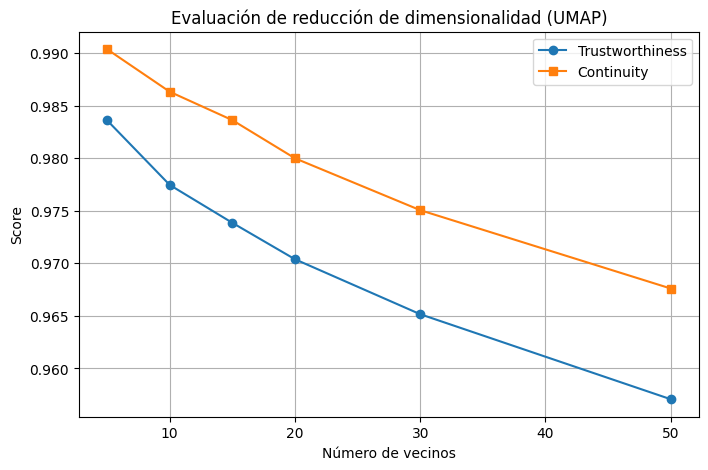

In [ ]:
X = datos_estandarizados  # Original
Y = datos_reducidos_umap  # Reducido

# --- Convertir a GPU ---
X_gpu = cp.asarray(X)
Y_gpu = cp.asarray(Y)

# --- Lista de vecinos para evaluar ---
n_neighbors_list = [5, 10, 15, 20, 30, 50]

# --- Inicialización ---
trust_scores = {k: 0.0 for k in n_neighbors_list}
continuity_scores = {k: 0.0 for k in n_neighbors_list}
n_samples = X_gpu.shape[0]

print("🔹 Evaluando Trustworthiness y Continuity fila por fila...")

# --- Iterar sobre cada punto ---
for i in tqdm(range(n_samples)):
    # Distancias al resto de puntos
    dist_X = cp.linalg.norm(X_gpu - X_gpu[i], axis=1)
    dist_Y = cp.linalg.norm(Y_gpu - Y_gpu[i], axis=1)

    # Rangos
    rank_X = cp.argsort(dist_X)
    rank_Y = cp.argsort(dist_Y)

    for k in n_neighbors_list:
        # Vecinos en exceso
        ux = cp.setdiff1d(rank_Y[:k], rank_X[:k])
        uy = cp.setdiff1d(rank_X[:k], rank_Y[:k])

        # Sumas de posiciones corregidas
        trust_scores[k] += cp.sum(cp.array([cp.where(rank_X == int(j))[0][0] + 1 for j in ux]))
        continuity_scores[k] += cp.sum(cp.array([cp.where(rank_Y == int(j))[0][0] + 1 for j in uy]))

# --- Normalización ---
trustworthiness = {}
continuity = {}
for k in n_neighbors_list:
    denom = n_samples * k * (2*n_samples - 3*k -1)
    trustworthiness[k] = 1 - (2.0 / denom) * trust_scores[k].get()  # De GPU a CPU
    continuity[k] = 1 - (2.0 / denom) * continuity_scores[k].get()

# --- Resultados ---
print("\n📊 Resultados Trustworthiness y Continuity:")
for k in n_neighbors_list:
    print(f"{k:>3} vecinos -> Trustworthiness: {trustworthiness[k]:.4f}, Continuity: {continuity[k]:.4f}")

# --- Gráfico ---
plt.figure(figsize=(8,5))
plt.plot(list(trustworthiness.keys()), list(trustworthiness.values()), 'o-', label='Trustworthiness')
plt.plot(list(continuity.keys()), list(continuity.values()), 's-', label='Continuity')
plt.xlabel("Número de vecinos")
plt.ylabel("Score")
plt.title("Evaluación de reducción de dimensionalidad (UMAP)")
plt.grid(True)
plt.legend()
plt.show()


La figura muestra los valores de Trustworthiness y Continuity para UMAP, ambos superiores a 0.95, lo que indica una representación de alta calidad que conserva la estructura original de los datos. Con los parámetros (n_factors_umap = 32, n_neighbors = 15, min_dist = 0.1, metric = 'euclidean'), UMAP mantiene mejor las relaciones locales, algo apropiado para imágenes oculares, donde es esencial preservar los pequeños rasgos diferenciadores entre muestras.

# Github

In [14]:
from google.colab import files
!cp "/content/drive/MyDrive/Colab Notebooks/EO.ipynb" "/content/"


In [17]:
import nbformat, os

ruta = "EO.ipynb"

if not os.path.exists(ruta):
    print(f"⚠️ No se encontró el archivo '{ruta}'. Verifica que esté en /content o descarga una copia desde Colab (Archivo → Descargar .ipynb).")
else:
    nb = nbformat.read(ruta, as_version=4)

    if "widgets" in nb.metadata:
        del nb.metadata["widgets"]
        nbformat.write(nb, ruta)
        print(f"✅ Se eliminaron los metadatos 'widgets' del archivo '{ruta}' correctamente.")
    else:
        print("ℹ️ El archivo no contenía metadatos 'widgets'. No se realizaron cambios.")


ℹ️ El archivo no contenía metadatos 'widgets'. No se realizaron cambios.


In [18]:
files.download("EO.ipynb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>